# Imports

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

# PCA Implementation

In [258]:
class PCA:
    def __init__(self, n_components):
        self.n = n_components

    def fit(self, X):
        cov = np.cov(X, rowvar=False)
        vals, vecs = np.linalg.eigh(cov)
        idx = np.argsort(vals)[::-1]
        self.vals = vals[idx]
        self.vecs = vecs[:, idx]
        self.components = self.vecs[:, :self.n]
        return self

    def transform(self, X):
        return X @ self.components

    def inverse_transform(self, Z):
        return Z @ self.components.T

    def reconstruction_error(self, X):
        Z = self.transform(X)
        X_hat = self.inverse_transform(Z)
        return np.mean((X - X_hat) ** 2)


# K-Means Implementation

In [260]:

class KMeans:
    def __init__(self, k, iters=100, init='kmeans++'):
        self.k = k
        self.iters = iters
        self.init = init

    def _init_centroids(self,X):
        n = X.shape[0]
        if self.init=='random':
            return X[np.random.choice(n,self.k,replace=False)]

        elif self.init=='kmeans++':
            centroids = [X[np.random.randint(0,n)]]
            for _ in range(1,self.k):
                dist = np.min([np.sum((X-c)**2,axis=1) for c in centroids],axis=0)

                # to avoid NaN
                if np.all(dist==0) or np.isnan(dist).any():
                    prob = np.ones(n)/n

                else:
                    prob = dist/dist.sum()
                centroids.append(X[np.random.choice(n,p=prob)])

            return np.array(centroids)

    def fit(self,X):
        n = X.shape[0]
        self.centroids = self._init_centroids(X)
        self.inertia_history = []

        for _ in range(self.iters):
            dists = np.linalg.norm(X[:,None]-self.centroids,axis=2)
            self.labels = np.argmin(dists,axis=1)

            new_centroids = np.array([X[self.labels==i].mean(axis=0) for i in range(self.k)])
            if np.allclose(self.centroids,new_centroids, atol=1e-6):
                break
            self.centroids = new_centroids

        self.inertia = np.sum((X-self.centroids[self.labels])**2)
        return self


# Autoencoder Implementation

In [262]:

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

class Autoencoder:
    def __init__(self, input_dim, bottleneck_dim,
                 hidden_dims=[64, 32, 16],
                 lr=0.01, l2=1e-4):

        self.lr0 = lr
        self.l2 = l2

        # Encoder + Decoder dimensions
        dims = [input_dim] + hidden_dims + [bottleneck_dim] \
               + hidden_dims[::-1] + [input_dim]

        self.W = []
        self.b = []

        for i in range(len(dims) - 1):
            self.W.append(np.random.randn(dims[i], dims[i+1]) * 0.01)
            self.b.append(np.zeros((1, dims[i+1])))

    def forward(self, X):
        self.A = [X]
        self.Z = []

        for i in range(len(self.W)):
            z = self.A[-1] @ self.W[i] + self.b[i]
            self.Z.append(z)

            if i == len(self.W) - 1:
                a = z
            else:
                a = relu(z)

            self.A.append(a)

        return self.A[-1]

    def backward(self, X):
        m = X.shape[0]
        dA = (self.A[-1] - X) / m

        for i in reversed(range(len(self.W))):
            if i == len(self.W) - 1:
                dZ = dA
            else:
                dZ = dA * relu_deriv(self.Z[i])

            dW = self.A[i].T @ dZ + self.l2 * self.W[i]
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = dZ @ self.W[i].T

            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    def fit(self, X, epochs=100, batch_size=64):
        self.loss_history = []

        for epoch in range(epochs):
            self.lr = self.lr0 * (0.95 ** epoch)  # LR scheduling
            perm = np.random.permutation(len(X))

            for i in range(0, len(X), batch_size):
                xb = X[perm[i:i+batch_size]]
                self.forward(xb)
                self.backward(xb)

            loss = np.mean((X - self.forward(X)) ** 2)
            self.loss_history.append(loss)

        return self

    def encode(self, X):
        A = X
        for i in range(len(self.W)):
            Z = A @ self.W[i] + self.b[i]
            if i == (len(self.W)//2 - 1):
                return Z
            A = relu(Z)

    def reconstruct(self, X):
        return self.forward(X)


# GMM Implementation

In [264]:
class GMM:
    def __init__(self, k, covariance_type='full', max_iters=100, tol=1e-4):
        self.k = k
        self.cov_type = covariance_type
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X):
        n, d = X.shape
        self.pi = np.ones(self.k) / self.k  # Mixing Weight "Prior"
        self.mu = X[np.random.choice(n, self.k, replace=False)]  # Mean -> Randomly Initalizing the mean on the start
        self.cov = np.array([np.eye(d) for _ in range(self.k)])  # Covariance Matrix
        self.log_likelihoods = []

        # E-Step
        for _ in range(self.max_iters):

            # Store unnormalized probabilities
            likelihood = np.zeros((n, self.k))

            for j in range(self.k):
                diff = X - self.mu[j]
                inv = np.linalg.inv(self.cov[j])
                expo = np.sum(diff @ inv * diff, axis=1)
                likelihood[:, j] = self.pi[j] * np.exp(-0.5 * expo)
                # Calculating how likely Point i is generated by Cluster j

            # Log-likelihood
            logL = np.sum(np.log(likelihood.sum(axis=1)))
            self.log_likelihoods.append(logL)

            # Normalization
            gamma = likelihood / likelihood.sum(axis=1, keepdims=True)
            Nk = gamma.sum(axis=0)

            # M-step
            self.pi = Nk / n
            self.mu = (gamma.T @ X) / Nk[:, None]

            # Covariance Matrix = (1/Nk)∑γik(xi−μk)(xi−μk)T
            for j in range(self.k):
                diff = X - self.mu[j]
                self.cov[j] = (gamma[:, j][:, None] * diff).T @ diff / Nk[j]
                self.cov[j] += 1e-6 * np.eye(d)

            # Reaching convergence
            if len(self.log_likelihoods) > 1 and \
               abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < self.tol:
                break

        # Converting soft clustering to hard labels
        self.labels = np.argmax(gamma, axis=1)
        return self


![52e5b96c-2d9d-424f-a1c7-fbe2b37e51b6.jfif](attachment:b0353e14-dc04-4cf3-88b7-3a56e6fdfd9c.jfif)

# Internal Validation Metrics Implementations

## Silhouette Score

In [268]:
#
def silhouette_score(X, labels):
    n = len(X)
    unique = np.unique(labels) #for finding all the clusters
    sil = []
    # a ->Intra-cluster distance , b->Nearst cluster distance
    for i in range(n):
        same = labels == labels[i]
        a = np.mean(np.linalg.norm(X[i] - X[same], axis=1)) # average distance bet points of the same cluster
        # min average distance bet points in the nearst other cluster
        b = np.min([
            np.mean(np.linalg.norm(X[i] - X[labels == l], axis=1))
            for l in unique if l != labels[i]
        ])
        sil.append((b - a) / max(a, b))

    return np.mean(sil)

![image.png](attachment:18239364-efd3-498b-a770-d44e24c29ce8.png)

In the Silhouette Score, we compute the average distance between a data point and other points in the same cluster (intra-cluster distance), and compare it with the minimum average distance to points in the nearest neighboring cluster. The objective is to form clusters with very small intra-cluster distances and large separation from the nearest other cluster.

## Davies Bouldin Index

In [271]:
def davies_bouldin(X, labels):
    clusters = np.unique(labels) # getting all the clusters we have
    centroids = np.array([X[labels == c].mean(axis=0) for c in clusters])
    S = np.array([
        np.mean(np.linalg.norm(X[labels == c] - centroids[i], axis=1))
        for i, c in enumerate(clusters)
    ])

    db = []
    for i in range(len(clusters)):
        ratios = []
        for j in range(len(clusters)):
            if i != j: # validation to skip the cluster itself
                ratios.append((S[i] + S[j]) /
                              np.linalg.norm(centroids[i] - centroids[j]))
        db.append(max(ratios))
    return np.mean(db)

![image.png](attachment:ff1c777a-37ac-472d-b0a7-9216478c579c.png)
Davies Bouldin index evaluates clustering quality by comparing the ratio of the intra-cluster to inter-clister sepeartion for each pair of clusters and our aim is for Low index and this can be achieved by having low intra-cluster scatter and large distance between cluster centroids

## Calinski Harabasz Index Implementation

In [274]:
def calinski_harabasz(X, labels):
    n = len(X) # total number of points
    clusters = np.unique(labels)
    overall_mean = X.mean(axis=0) # calculating the global centroid for all the clusters
    # Higher Calinski-Harabasz index better clustering
    B, W = 0, 0 # B -> Between-cluster dispersion , W -> Within-cluster dispersion
    for c in clusters:
        Xc = X[labels == c]
        mean_c = Xc.mean(axis=0)
        B += len(Xc) * np.sum((mean_c - overall_mean) ** 2) # the further the centroid the better
        W += np.sum((Xc - mean_c) ** 2) # the smaller the dispersion the better

    return (B / (len(clusters) - 1)) / (W / (n - len(clusters))) # len here just for normaliziation

![image.png](attachment:6db86575-1964-4f52-87f2-377f7ecffedd.png)

The Calinski–Harabasz Index evaluates clustering quality by computing the ratio of between-cluster dispersion to within-cluster dispersion, normalized by the number of clusters and points. A higher value indicates well-separated and compact clusters.

## BIC & AIC

In [277]:
def compute_bic(logL, n_params, n_samples): # Bayesian Information Criterion
    return -2 * logL + n_params * np.log(n_samples) #LogL is log of the likelihood , the lower the better in BIC

def compute_aic(logL, n_params): # Akaike Information Criterion
    return -2 * logL + 2 * n_params

def gmm_num_params(k, d, cov_type):
    if cov_type == 'full':
        return k * (d + d*(d+1)//2) + (k - 1)
    elif cov_type == 'tied':
        return k * d + d*(d+1)//2 + (k - 1)
    elif cov_type == 'diag':
        return k * (2*d) + (k - 1)
    elif cov_type == 'spherical':
        return k * (d + 1) + (k - 1)


# External Validation Metrics Implementation

## ARI implementation

In [280]:
def adjusted_rand_index(true_labels, pred_labels):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    n = len(true_labels)

    # Unique classes and clusters
    classes = np.unique(true_labels)
    clusters = np.unique(pred_labels)

    # Contingency table
    contingency = np.zeros((len(classes), len(clusters)), dtype=int)

    for i, c in enumerate(classes):
        for j, k in enumerate(clusters):
            contingency[i, j] = np.sum((true_labels == c) & (pred_labels == k))

    def comb2(x):
        return x * (x - 1) // 2

    sum_nij = np.sum(comb2(contingency))
    sum_ai = np.sum(comb2(contingency.sum(axis=1)))
    sum_bj = np.sum(comb2(contingency.sum(axis=0)))
    total = comb2(n)

    expected = (sum_ai * sum_bj) / total
    max_index = 0.5 * (sum_ai + sum_bj)

    ari = (sum_nij - expected) / (max_index - expected)

    return ari

## NMI implementation

In [282]:
def normalized_mutual_information(true_labels, pred_labels):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    n = len(true_labels)

    classes = np.unique(true_labels)
    clusters = np.unique(pred_labels)

    # Contingency table
    contingency = np.zeros((len(classes), len(clusters)), dtype=float)

    for i, c in enumerate(classes):
        for j, k in enumerate(clusters):
            contingency[i, j] = np.sum((true_labels == c) & (pred_labels == k))

    # Probabilities
    Pij = contingency / n
    Pi = Pij.sum(axis=1)
    Pj = Pij.sum(axis=0)

    # Mutual Information
    MI = 0.0
    for i in range(len(Pi)):
        for j in range(len(Pj)):
            if Pij[i, j] > 0:
                MI += Pij[i, j] * np.log(Pij[i, j] / (Pi[i] * Pj[j]))

    # Entropies
    HY = -np.sum(Pi[Pi > 0] * np.log(Pi[Pi > 0]))
    HC = -np.sum(Pj[Pj > 0] * np.log(Pj[Pj > 0]))

    # Normalized MI
    NMI = 2 * MI / (HY + HC)

    return NMI


## Purity Score Implementation

In [284]:
def purity_score(y_true, y_pred):
    total = 0
    for c in np.unique(y_pred):
        _, counts = np.unique(y_true[y_pred == c], return_counts=True)
        total += counts.max()
    return total / len(y_true)

# Data Loading & Preprocessing

In [286]:

def load_and_preprocess(path):
    df = pd.read_csv(path)
    y = (df['diagnosis'] == 'M').astype(int).values
    X = df.drop(columns=['id','diagnosis'], errors='ignore').values.astype(float)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    # Standardization
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1
    X = (X - mean) / std

    return X, y

# Load dataset
X, y = load_and_preprocess("breast_cancer.csv")
print("Data shape:", X.shape, "Labels shape:", y.shape)

Data shape: (569, 31) Labels shape: (569,)


# Experiments

## Experiment 1: K-Means on original data

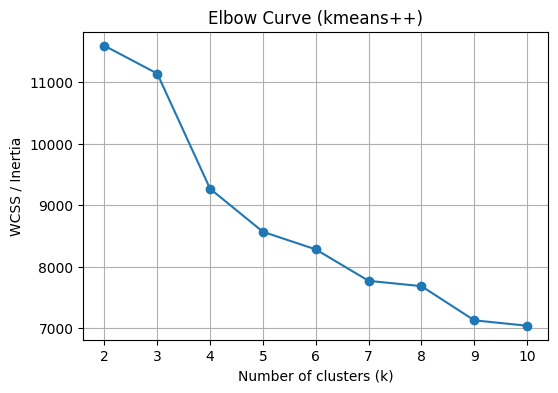

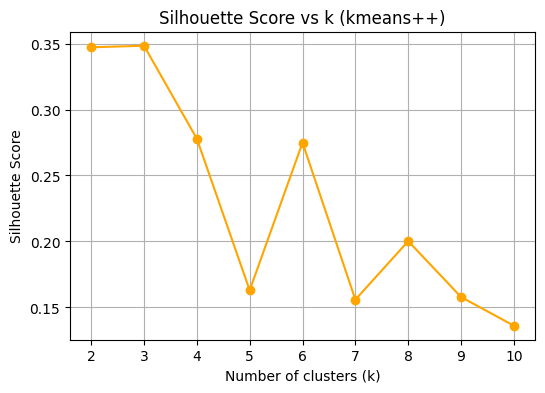

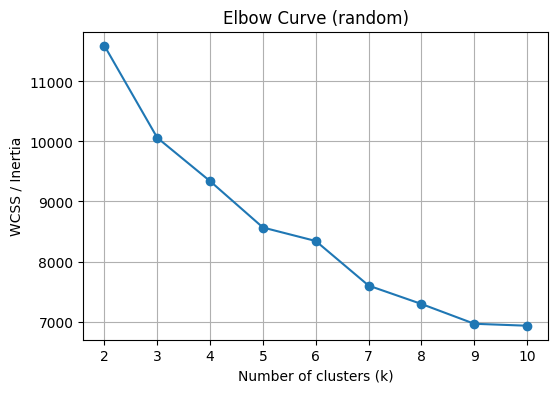

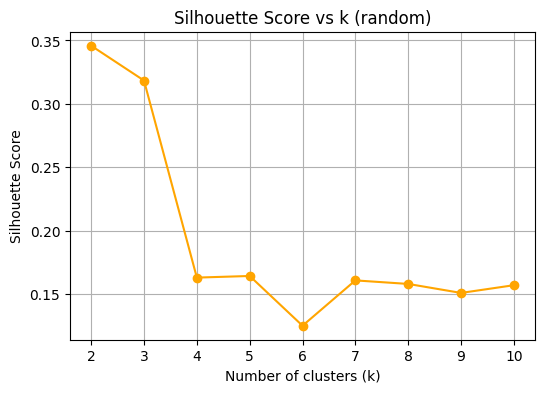

In [289]:
results_exp1 = []

k_values = range(2, 11)

for init_type in ['kmeans++', 'random']:
    inertia_list = []
    silhouette_list = []

    for k in k_values:
        km = KMeans(k=k, iters=100, init=init_type)
        km.fit(X)

        labels = km.labels
        inertia_list.append(km.inertia)
        silhouette_list.append(silhouette_score(X, labels))

        # Save results
        results_exp1.append({
            "Experiment": "KMeans Original",
            "Init": init_type,
            "k": k,
            "WCSS": km.inertia,
            "Silhouette": silhouette_score(X, labels),
            "DB": davies_bouldin(X, labels),
            "CH": calinski_harabasz(X, labels),
            "ARI": adjusted_rand_index(y, labels),
            "NMI": normalized_mutual_information(y, labels),
            "Purity": purity_score(y, labels),
            "Iterations": len(km.inertia_history)
        })

    # Plot Elbow Curve
    plt.figure(figsize=(6,4))
    plt.plot(k_values, inertia_list, marker='o')
    plt.title(f"Elbow Curve ({init_type})")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("WCSS / Inertia")
    plt.grid(True)
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(6,4))
    plt.plot(k_values, silhouette_list, marker='o', color='orange')
    plt.title(f"Silhouette Score vs k ({init_type})")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()


## Experiment 2: GMM on original data

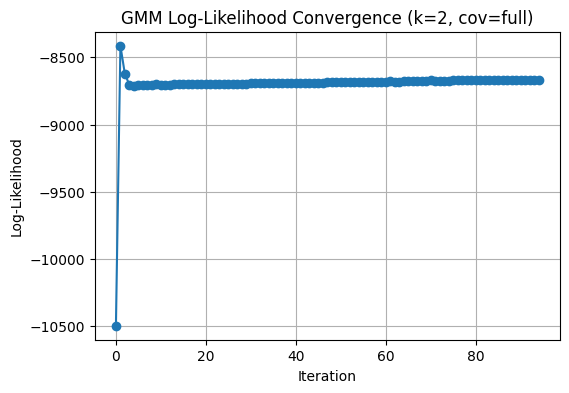

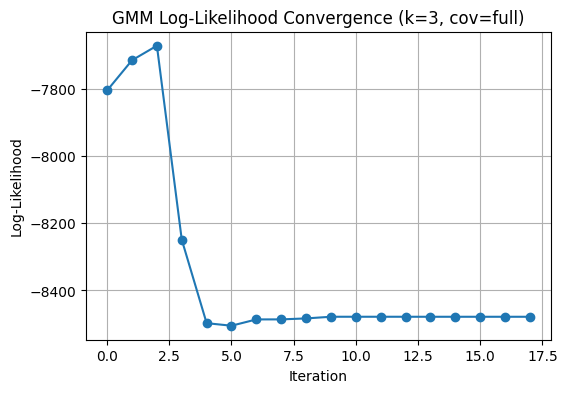

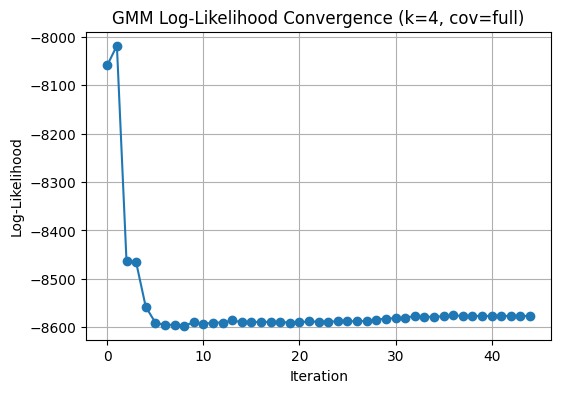

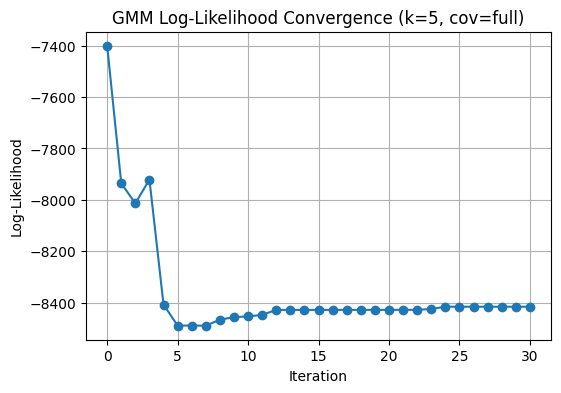

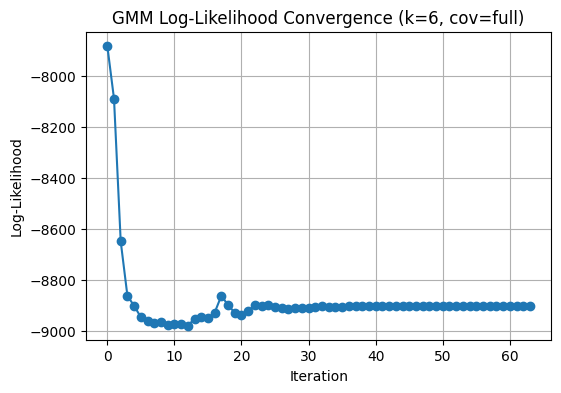

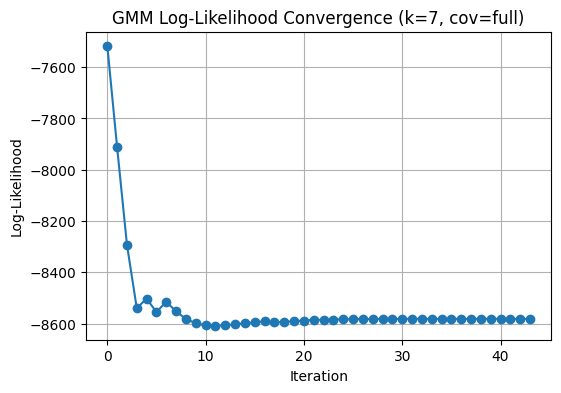

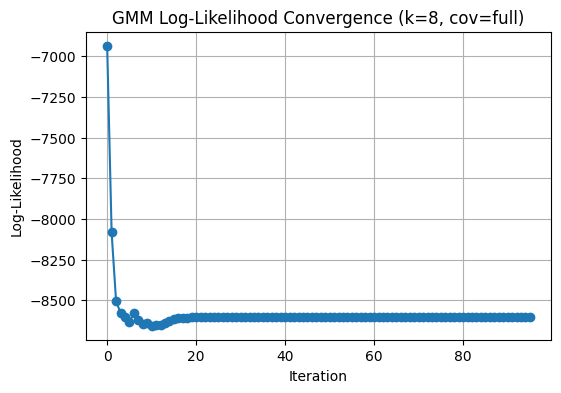

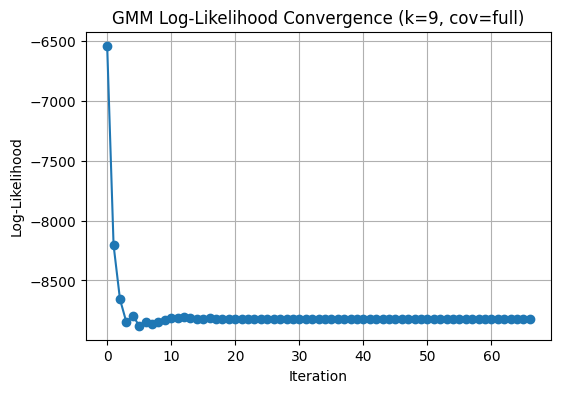

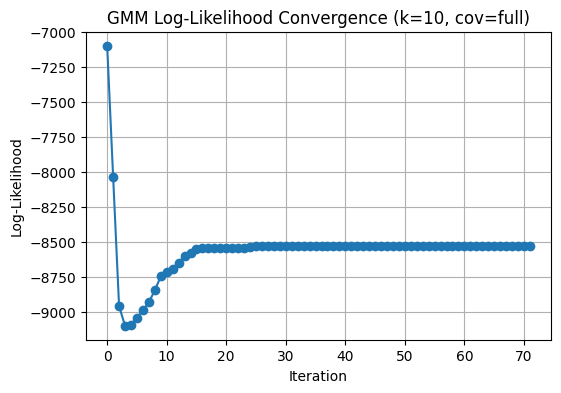

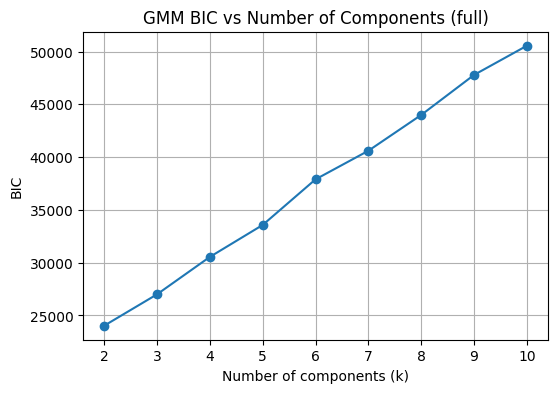

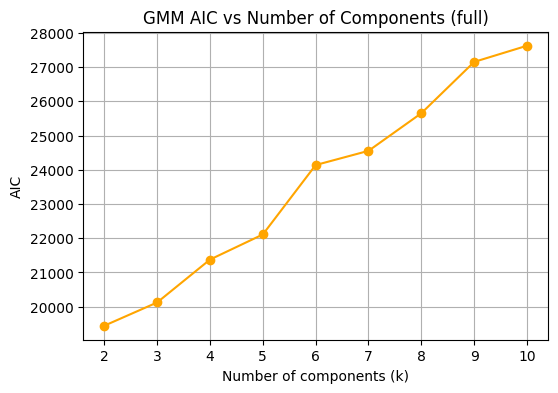

In [291]:
results_exp2 = []

cov_type = 'full'
n_samples, d = X.shape
k_values = range(2, 11)

# Run GMM for different k values
for k in k_values:
    gmm = GMM(k=k, covariance_type=cov_type, max_iters=100).fit(X)
    labels = gmm.labels
    logL = gmm.log_likelihoods[-1]
    n_params = gmm_num_params(k, d, cov_type)

    # Save metrics
    results_exp2.append({
        "Experiment": "GMM Original",
        "Covariance": cov_type,
        "k": k,
        "Silhouette": silhouette_score(X, labels),
        "DB": davies_bouldin(X, labels),
        "CH": calinski_harabasz(X, labels),
        "Purity": purity_score(y, labels),
        "LogL": logL,
        "BIC": compute_bic(logL, n_params, n_samples),
        "AIC": compute_aic(logL, n_params)
    })

    # Optional: Log-Likelihood convergence plot for this k
    plt.figure(figsize=(6,4))
    plt.plot(gmm.log_likelihoods, marker='o')
    plt.title(f"GMM Log-Likelihood Convergence (k={k}, cov={cov_type})")
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.grid(True)
    plt.show()

# Plot BIC vs k
BIC_values = [r['BIC'] for r in results_exp2]
plt.figure(figsize=(6,4))
plt.plot(k_values, BIC_values, marker='o')
plt.title(f"GMM BIC vs Number of Components ({cov_type})")
plt.xlabel("Number of components (k)")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

# Plot AIC vs k
AIC_values = [r['AIC'] for r in results_exp2]
plt.figure(figsize=(6,4))
plt.plot(k_values, AIC_values, marker='o', color='orange')
plt.title(f"GMM AIC vs Number of Components ({cov_type})")
plt.xlabel("Number of components (k)")
plt.ylabel("AIC")
plt.grid(True)
plt.show()

## Experiment 3: K-Means after PCA

Dims= 2 | Inertia= 5332.98 | ReconErr=0.3557 | ExplVar=0.6324 | Sil=0.5100 | DB=0.8441 | CH=580.78 | Purity=0.9086 | ARI=0.6650 | NMI=0.5474


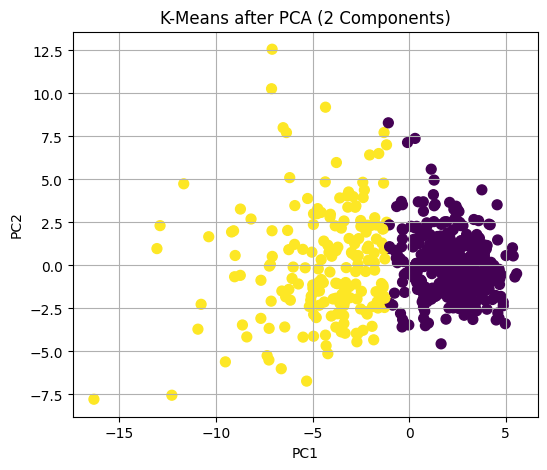

Dims= 5 | Inertia= 8992.28 | ReconErr=0.1477 | ExplVar=0.8473 | Sil=0.3932 | DB=1.1438 | CH=345.02 | Purity=0.9104 | ARI=0.6709 | NMI=0.5516


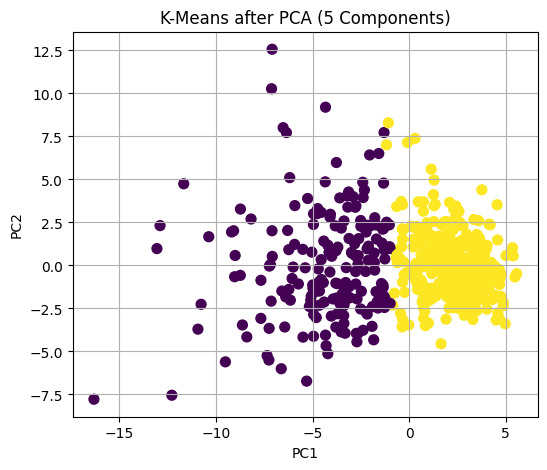

Dims=10 | Inertia=10770.55 | ReconErr=0.0469 | ExplVar=0.9516 | Sil=0.3588 | DB=1.2679 | CH=288.10 | Purity=0.9051 | ARI=0.6536 | NMI=0.5324


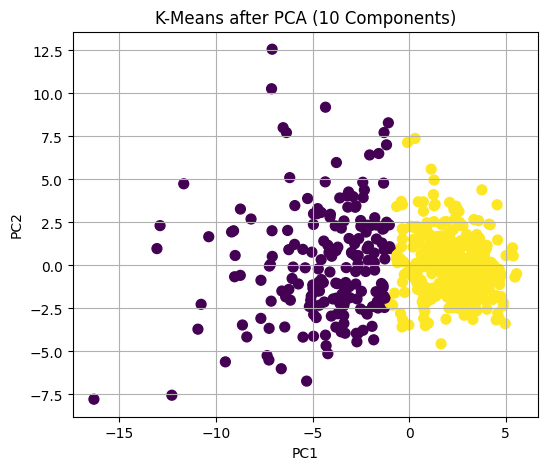

Dims=15 | Inertia=11365.42 | ReconErr=0.0131 | ExplVar=0.9865 | Sil=0.3492 | DB=1.3061 | CH=273.08 | Purity=0.9051 | ARI=0.6536 | NMI=0.5324


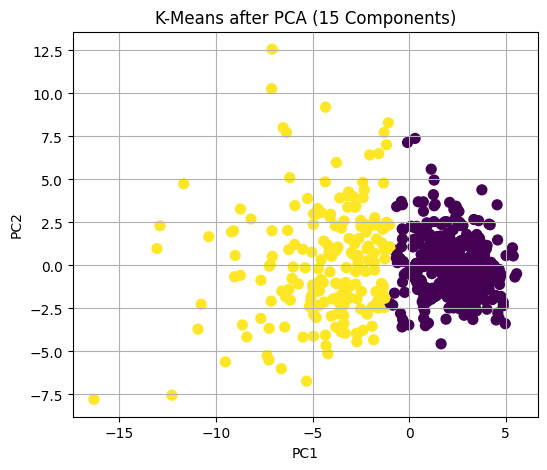

Dims=20 | Inertia=11520.00 | ReconErr=0.0043 | ExplVar=0.9956 | Sil=0.3469 | DB=1.3156 | CH=269.44 | Purity=0.9051 | ARI=0.6536 | NMI=0.5324


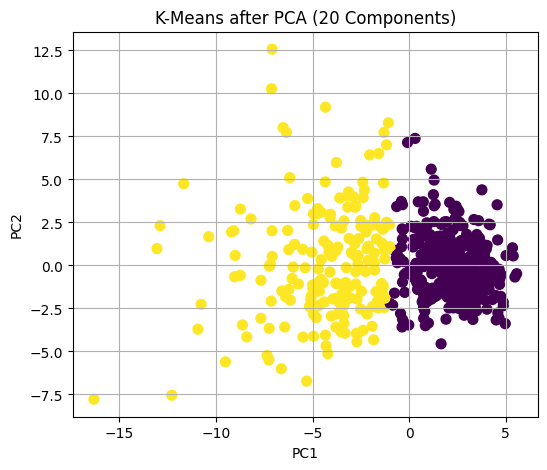

Dim | Inertia | Recon Error | Explained Var | Silhouette |  DB    |    CH   |  Purity | ARI    | NMI
----------------------------------------------------------------------------------------------------
  2 |  5332.98 |      0.3557 |        0.6324 |     0.5100 | 0.8441 | 580.78 |  0.9086 | 0.6650 | 0.5474
  5 |  8992.28 |      0.1477 |        0.8473 |     0.3932 | 1.1438 | 345.02 |  0.9104 | 0.6709 | 0.5516
 10 | 10770.55 |      0.0469 |        0.9516 |     0.3588 | 1.2679 | 288.10 |  0.9051 | 0.6536 | 0.5324
 15 | 11365.42 |      0.0131 |        0.9865 |     0.3492 | 1.3061 | 273.08 |  0.9051 | 0.6536 | 0.5324
 20 | 11520.00 |      0.0043 |        0.9956 |     0.3469 | 1.3156 | 269.44 |  0.9051 | 0.6536 | 0.5324


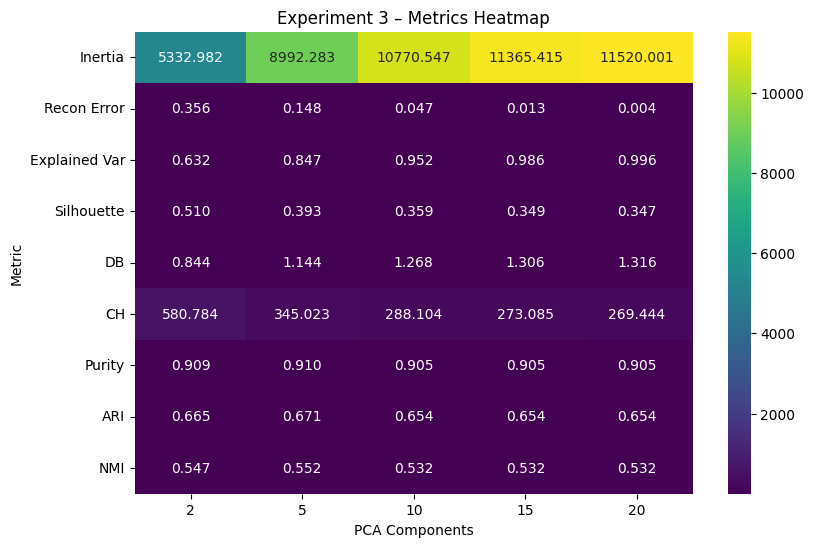

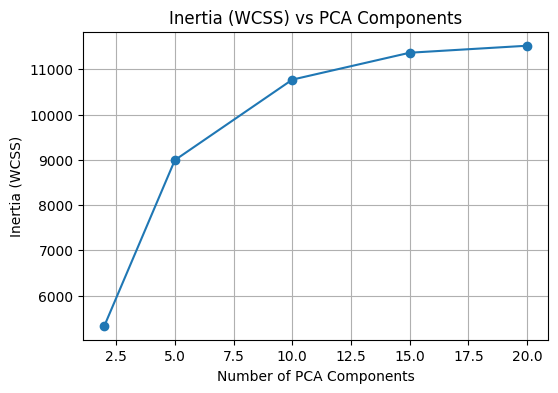

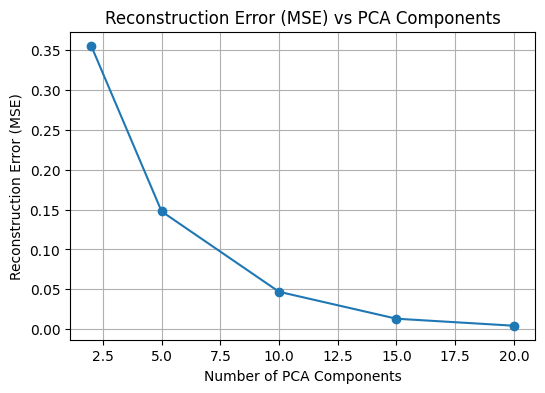

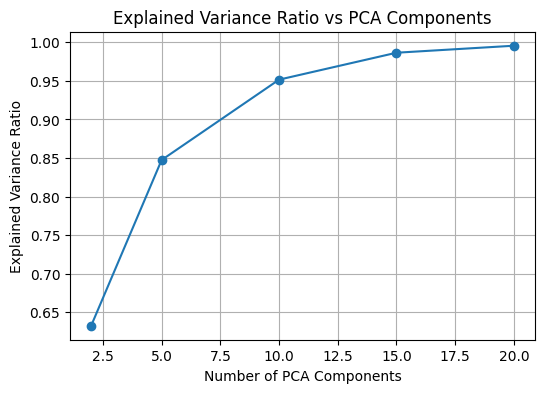

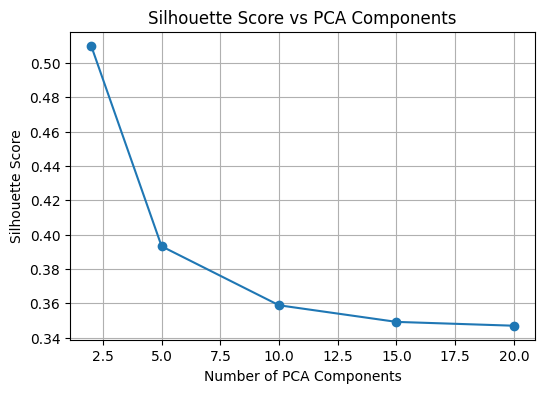

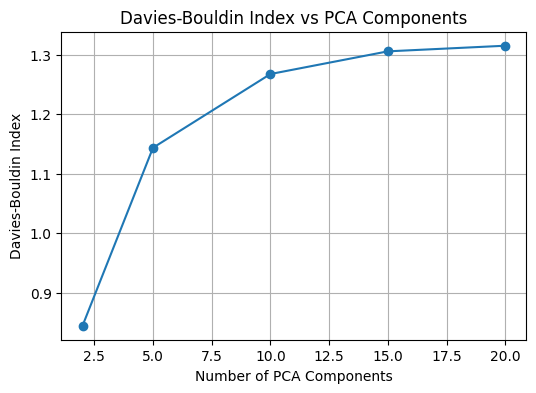

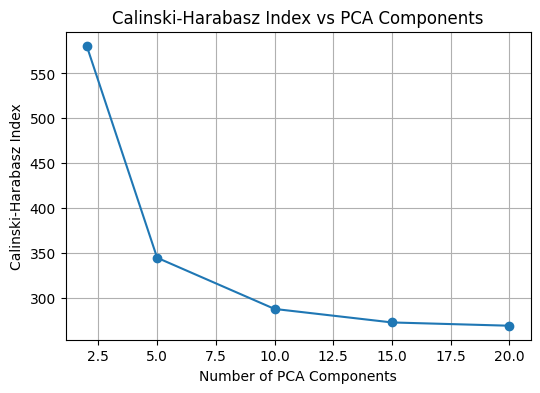

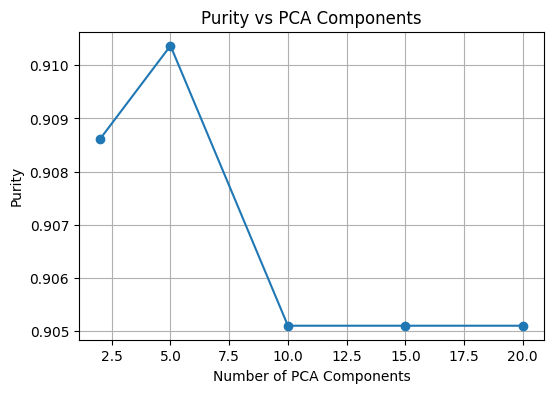

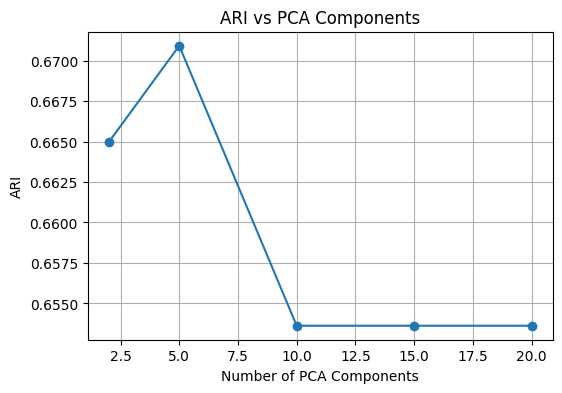

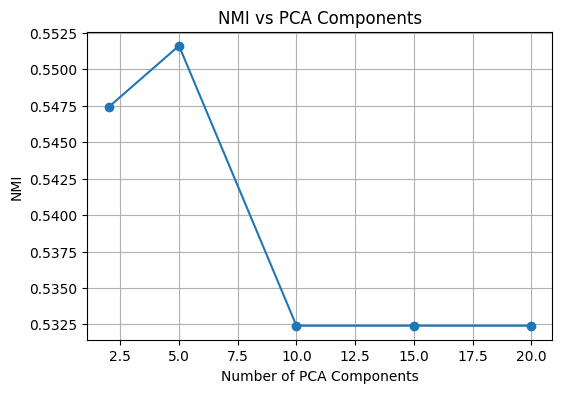

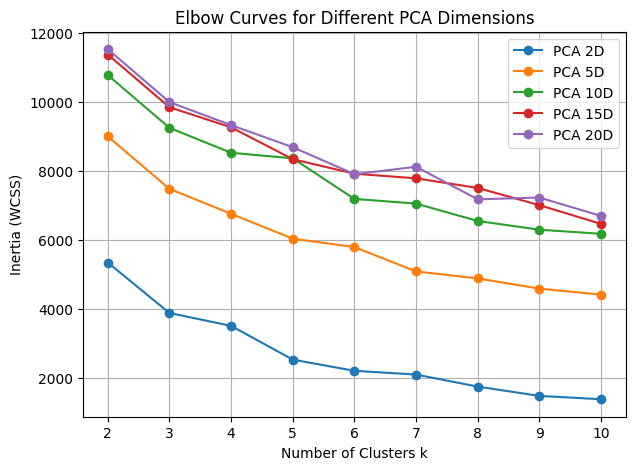

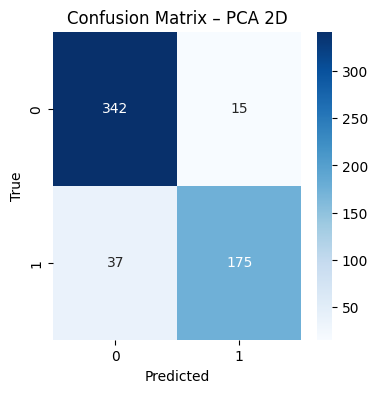

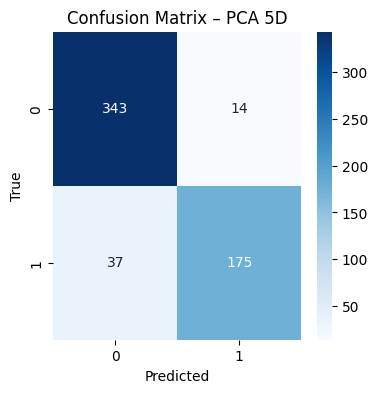

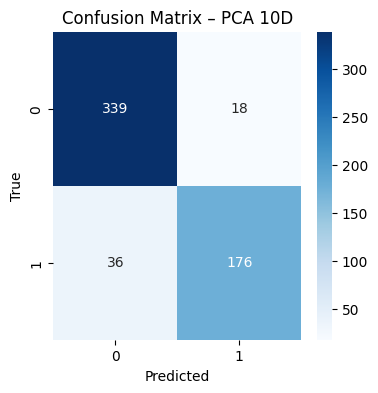

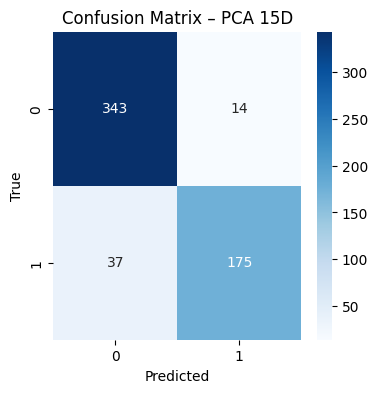

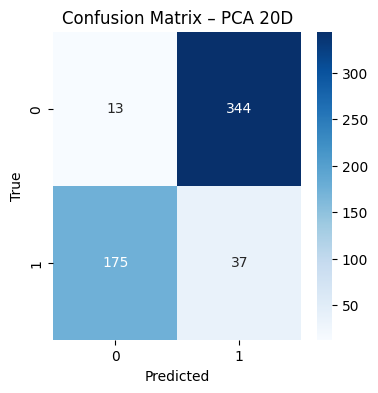

In [293]:
# Results array for final comparison
results_exp3 = []

dims_list = [2, 5, 10, 15, 20]

inertia_list = []
recon_list = []
explained_var_list = []
silhouette_list = []
db_list = []
ch_list = []
purity_list = []

# New lists for external metrics
ari_list = []
nmi_list = []



# Run experiment
for d in dims_list:
    pca = PCA(d).fit(X)
    Z = pca.transform(X)

    km = KMeans(2, iters=50, init='kmeans++').fit(Z)

    inertia_list.append(km.inertia)
    recon_list.append(pca.reconstruction_error(X))
    explained_var_list.append(np.sum(pca.vals[:d]) / np.sum(pca.vals))
    silhouette_list.append(silhouette_score(Z, km.labels))
    db_list.append(davies_bouldin(Z, km.labels))
    ch_list.append(calinski_harabasz(Z, km.labels))
    purity_list.append(purity_score(y, km.labels))

    # Compute ARI and NMI
    ari = adjusted_rand_index(y, km.labels)
    nmi = normalized_mutual_information(y, km.labels)
    ari_list.append(ari)
    nmi_list.append(nmi)

    # Store results for comparison
    results_exp3.append({
        "Experiment": "KMeans + PCA",
        "PCA_dim": d,
        "k": 2,
        "WCSS": km.inertia,
        "Silhouette": silhouette_score(Z, km.labels),
        "DB": davies_bouldin(Z, km.labels),
        "CH": calinski_harabasz(Z, km.labels),
        "Purity": purity_score(y, km.labels),
        "ARI": ari,
        "NMI": nmi,
        "ReconError": pca.reconstruction_error(X),
        "ExplVar": np.sum(pca.vals[:d]) / np.sum(pca.vals)
    })

    print(
        f"Dims={d:2d} | "
        f"Inertia={km.inertia:8.2f} | "
        f"ReconErr={recon_list[-1]:.4f} | "
        f"ExplVar={explained_var_list[-1]:.4f} | "
        f"Sil={silhouette_list[-1]:.4f} | "
        f"DB={db_list[-1]:.4f} | "
        f"CH={ch_list[-1]:.2f} | "
        f"Purity={purity_list[-1]:.4f} | "
        f"ARI={ari:.4f} | NMI={nmi:.4f}"
    )

    # 2D Scatter (always first 2 PCs)
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=km.labels, cmap='viridis', s=50)
    plt.title(f"K-Means after PCA ({d} Components)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

# ==== Report Results ====
print("Dim | Inertia | Recon Error | Explained Var | Silhouette |  DB    |    CH   |  Purity | ARI    | NMI")
print("-"*100)

for i, d in enumerate(dims_list):
    print(
        f"{d:>3} | "
        f"{inertia_list[i]:>8.2f} | "
        f"{recon_list[i]:>11.4f} | "
        f"{explained_var_list[i]:>13.4f} | "
        f"{silhouette_list[i]:>10.4f} | "
        f"{db_list[i]:>5.4f} | "
        f"{ch_list[i]:>6.2f} | "
        f"{purity_list[i]:>7.4f} | "
        f"{ari_list[i]:>5.4f} | "
        f"{nmi_list[i]:>5.4f}"
    )

# The rest of your plotting (metrics plots, elbow curves, heatmap, confusion matrices) stays exactly the same
# Heatmap of metrics
metrics_df = pd.DataFrame({
    "Inertia": inertia_list,
    "Recon Error": recon_list,
    "Explained Var": explained_var_list,
    "Silhouette": silhouette_list,
    "DB": db_list,
    "CH": ch_list,
    "Purity": purity_list,
    "ARI": ari_list,
    "NMI": nmi_list
}, index=dims_list)

plt.figure(figsize=(9,6))
sns.heatmap(metrics_df.T, annot=True, fmt=".3f", cmap="viridis")
plt.title("Experiment 3 – Metrics Heatmap")
plt.xlabel("PCA Components")
plt.ylabel("Metric")
plt.show()


# Plot each metric separately
metrics = {
    "Inertia (WCSS)": inertia_list,
    "Reconstruction Error (MSE)": recon_list,
    "Explained Variance Ratio": explained_var_list,
    "Silhouette Score": silhouette_list,
    "Davies-Bouldin Index": db_list,
    "Calinski-Harabasz Index": ch_list,
    "Purity": purity_list,
    "ARI": ari_list,
    "NMI": nmi_list
}

for name, values in metrics.items():
    plt.figure(figsize=(6,4))
    plt.plot(dims_list, values, marker='o')
    plt.xlabel("Number of PCA Components")
    plt.ylabel(name)
    plt.title(f"{name} vs PCA Components")
    plt.grid(True)
    plt.show()


# Elbow Curve (WCSS vs k)
k_values = range(2, 11)

plt.figure(figsize=(7,5))
for d in dims_list:
    pca = PCA(d).fit(X)
    Z = pca.transform(X)

    inertia_k = []
    for k in k_values:
        km = KMeans(k, iters=100, init='kmeans++').fit(Z)
        inertia_k.append(km.inertia)

    plt.plot(k_values, inertia_k, marker='o', label=f'PCA {d}D')

plt.xlabel("Number of Clusters k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Curves for Different PCA Dimensions")
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrices
from sklearn.metrics import confusion_matrix

for d in dims_list:
    pca = PCA(d).fit(X)
    Z = pca.transform(X)
    km = KMeans(2, iters=50, init='kmeans++').fit(Z)

    cm = confusion_matrix(y, km.labels)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix – PCA {d}D")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


## Experiment 4: GMM after PCA

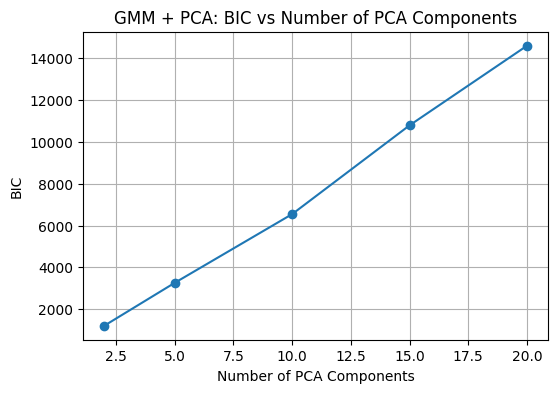

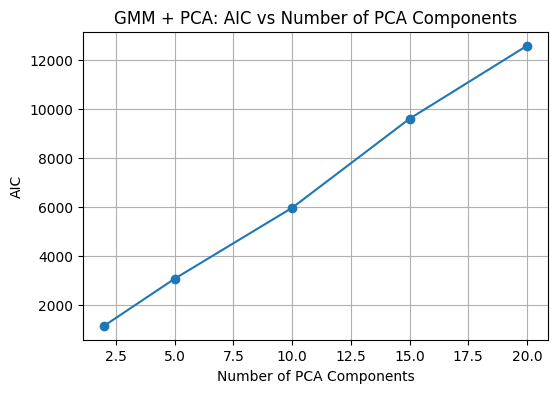

In [295]:
results_exp4 = []
p_values = [2, 5, 10, 15, 20]

for p in p_values:
    Xp = PCA(p).fit(X).transform(X)
    gmm = GMM(2, covariance_type='full', max_iters=100).fit(Xp)
    labels = gmm.labels

    logL = gmm.log_likelihoods[-1]
    n_params = gmm_num_params(2, p, "full")

    if len(np.unique(labels)) > 1:
        sil = silhouette_score(Xp, labels)
        db = davies_bouldin(Xp, labels)
        ch = calinski_harabasz(Xp, labels)
    else:
        sil = np.nan
        db = np.nan
        ch = np.nan

    results_exp4.append({
        "Experiment": f"GMM + PCA ({p})",
        "Silhouette": sil,
        "DB": db,
        "CH": ch,
        "Purity": purity_score(y, labels),
        "LogL": logL,
        "BIC": compute_bic(logL, n_params, n_samples),
        "AIC": compute_aic(logL, n_params)
    })

BIC_values = [r['BIC'] for r in results_exp4]
plt.figure(figsize=(6,4))
plt.plot(p_values, BIC_values, marker='o')
plt.title("GMM + PCA: BIC vs Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

AIC_values = [r['AIC'] for r in results_exp4]
plt.figure(figsize=(6,4))
plt.plot(p_values, AIC_values, marker='o')
plt.title("GMM + PCA: AIC vs Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("AIC")
plt.grid(True)
plt.show()

# Experiment 5: K-Means after Autoencoder


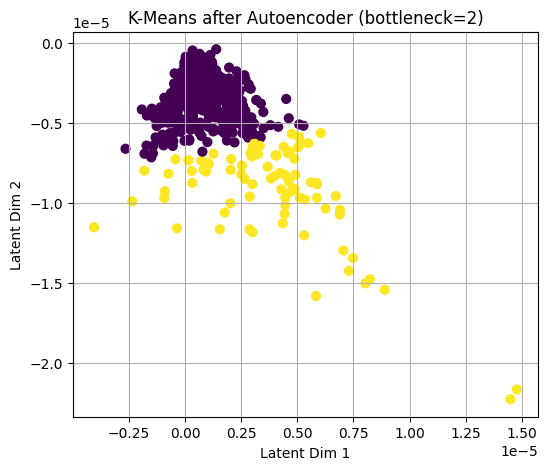

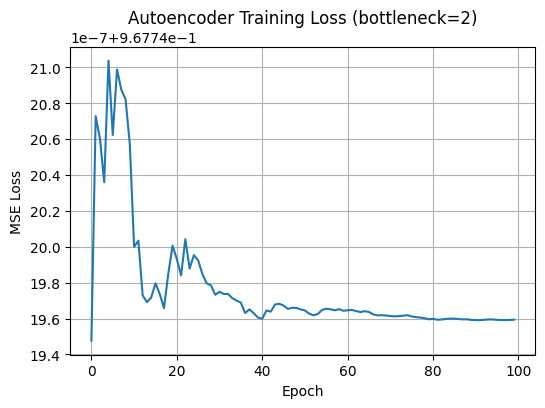

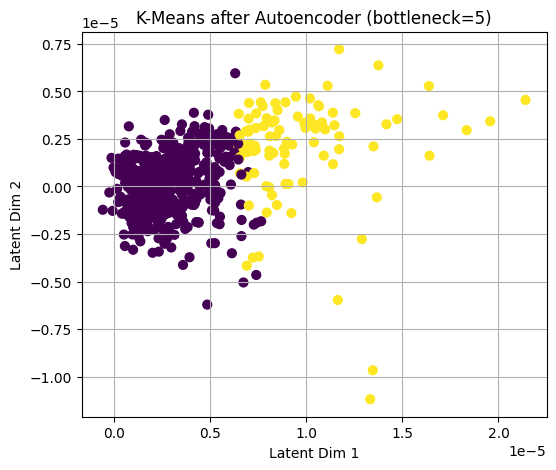

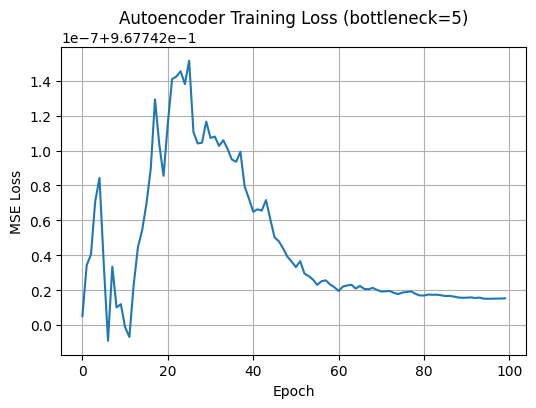

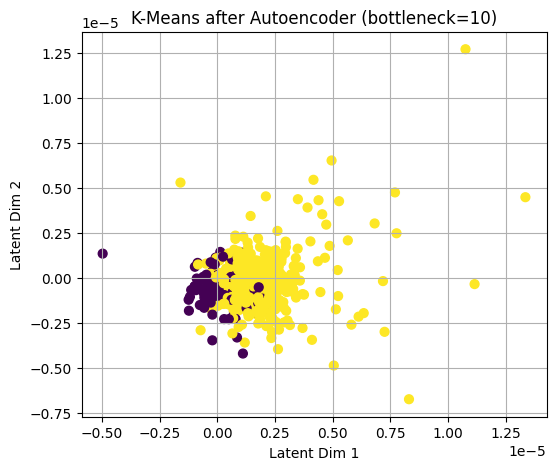

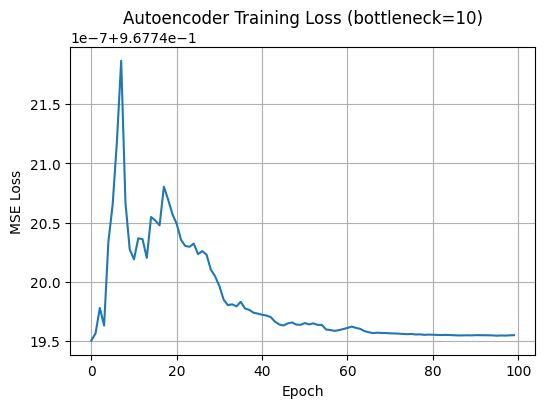

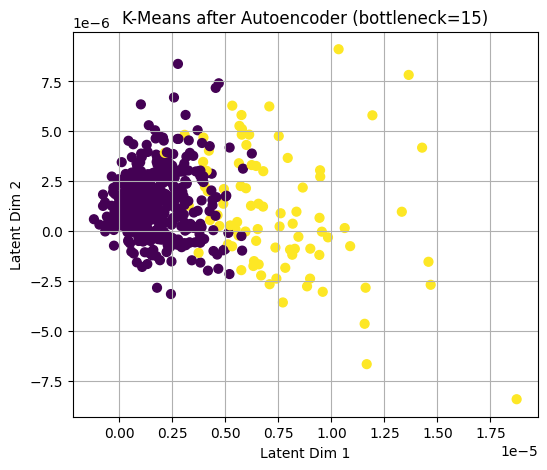

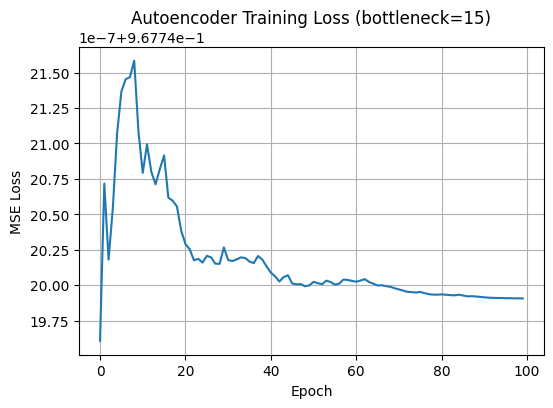

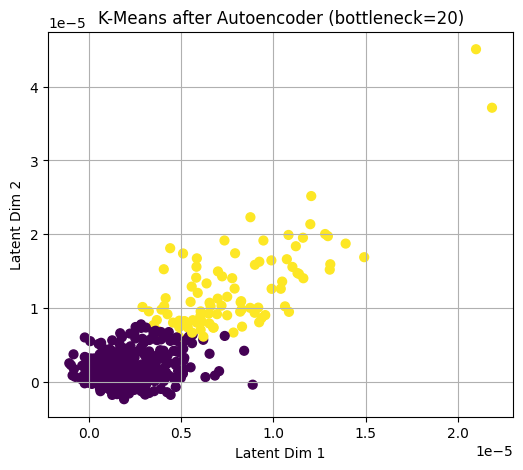

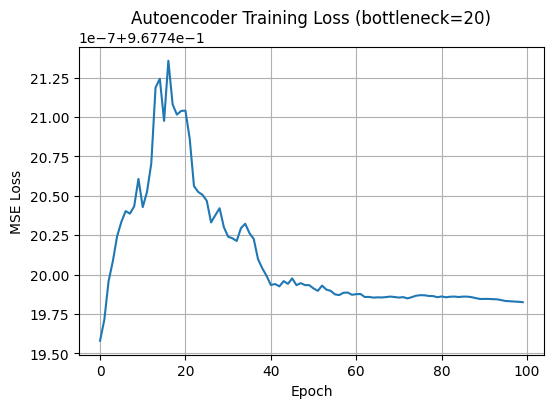

In [297]:
results_exp5 = []
bottleneck_dims = [2, 5, 10, 15, 20]

for d in bottleneck_dims:
    ae = Autoencoder(input_dim=X.shape[1], bottleneck_dim=d)
    ae.fit(X, epochs=100)

    Z = ae.encode(X)
    recon_error = np.mean((X - ae.reconstruct(X)) ** 2)

    km = KMeans(k=2, iters=100, init='kmeans++')
    km.fit(Z)

    labels = km.labels

    results_exp5.append({
        "Experiment": "KMeans + Autoencoder",
        "Bottleneck": d,
        "WCSS": km.inertia,
        "Silhouette": silhouette_score(Z, labels),
        "DB": davies_bouldin(Z, labels),
        "CH": calinski_harabasz(Z, labels),
        "Purity": purity_score(y, labels),
        "ARI": adjusted_rand_index(y, labels),
        "NMI": normalized_mutual_information(y, labels),
        "ReconError": recon_error
    })

    # 2D visualization
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=labels, cmap='viridis', s=40)
    plt.title(f"K-Means after Autoencoder (bottleneck={d})")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.grid(True)
    plt.show()

    # Training loss curve
    plt.figure(figsize=(6,4))
    plt.plot(ae.loss_history)
    plt.title(f"Autoencoder Training Loss (bottleneck={d})")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()


# Experiment 6: GMM after Autoencoder


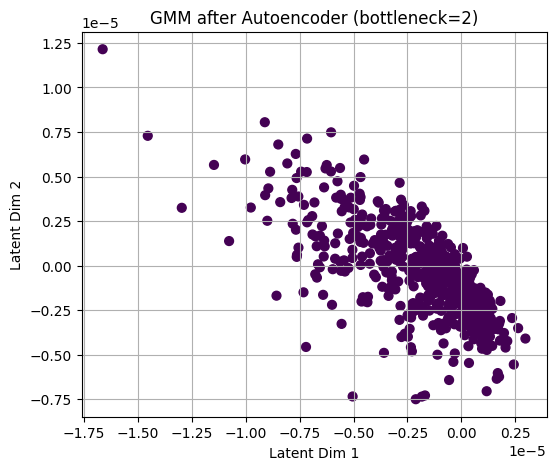

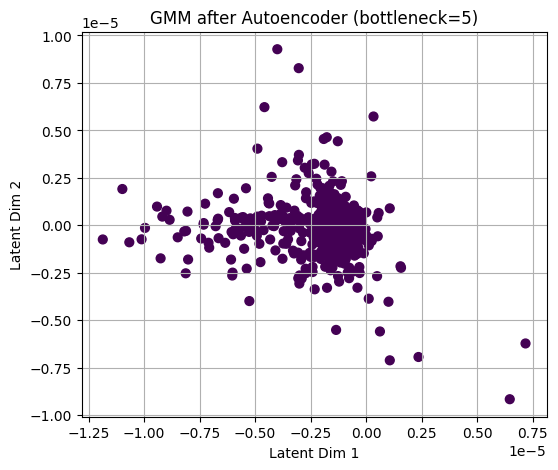

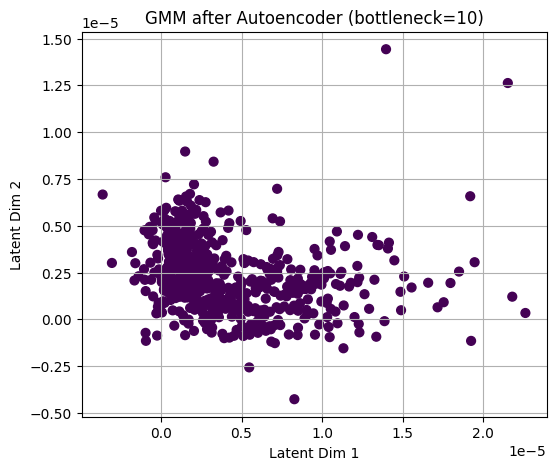

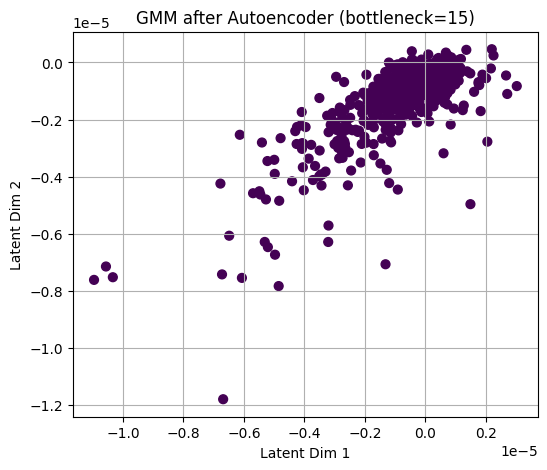

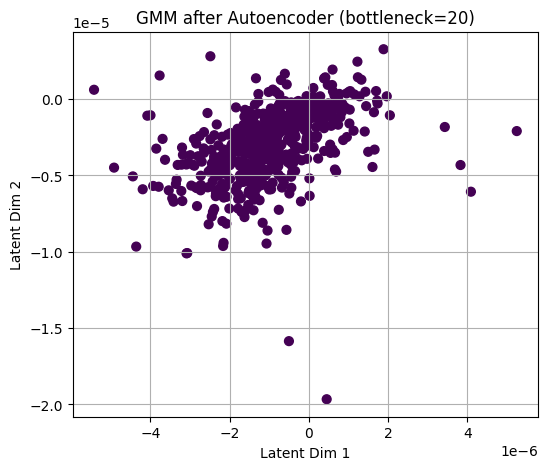

In [299]:
results_exp6 = []

n_samples, d_original = X.shape

for d in bottleneck_dims:
    ae = Autoencoder(input_dim=X.shape[1], bottleneck_dim=d)
    ae.fit(X, epochs=100)

    Z = ae.encode(X)

    gmm = GMM(k=2, covariance_type='full', max_iters=100)
    gmm.fit(Z)

    labels = gmm.labels
    logL = gmm.log_likelihoods[-1]

    n_params = gmm_num_params(2, d, 'full')

    # Handle cases where GMM might only find one cluster
    num_unique_labels = len(np.unique(labels))
    if num_unique_labels > 1:
        sil = silhouette_score(Z, labels)
        db_score = davies_bouldin(Z, labels)
        ch_score = calinski_harabasz(Z, labels)
    else:
        sil = np.nan
        db_score = np.nan
        ch_score = np.nan

    results_exp6.append({
        "Experiment": "GMM + Autoencoder",
        "Bottleneck": d,
        "Silhouette": sil,
        "DB": db_score,
        "CH": ch_score,
        "Purity": purity_score(y, labels),
        "ARI": adjusted_rand_index(y, labels),
        "NMI": normalized_mutual_information(y, labels),
        "LogL": logL,
        "BIC": compute_bic(logL, n_params, n_samples),
        "AIC": compute_aic(logL, n_params)
    })

    # 2D visualization
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=labels, cmap='viridis', s=40)
    plt.title(f"GMM after Autoencoder (bottleneck={d})")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.grid(True)
    plt.show()

In [300]:
all_results = pd.concat([
    pd.DataFrame(results_exp1),
    pd.DataFrame(results_exp2),
    pd.DataFrame(results_exp3),
    pd.DataFrame(results_exp4),
    pd.DataFrame(results_exp5),
    pd.DataFrame(results_exp6)
], ignore_index=True)


common_cols = [
    'Experiment',
    'k',
    'Silhouette',
    'DB',
    'CH',
    'Purity'
]


all_results_common = all_results.reindex(columns=common_cols)

print(all_results_common)


              Experiment     k  Silhouette        DB          CH    Purity
0        KMeans Original   2.0    0.347165  1.309289  267.680436  0.912127
1        KMeans Original   3.0    0.348359  1.087509  150.568001  0.917399
2        KMeans Original   4.0    0.277883  1.492743  158.616513  0.910369
3        KMeans Original   5.0    0.163007  1.764043  139.993951  0.922671
4        KMeans Original   6.0    0.274883  1.377545  119.565838  0.922671
5        KMeans Original   7.0    0.155900  1.616577  112.192070  0.940246
6        KMeans Original   8.0    0.200245  1.487526   97.980756  0.931459
7        KMeans Original   9.0    0.157900  1.557659   97.738163  0.913884
8        KMeans Original  10.0    0.136143  1.580811   88.576344  0.927944
9        KMeans Original   2.0    0.345808  1.320510  267.691716  0.905097
10       KMeans Original   3.0    0.318337  1.529388  197.114000  0.869947
11       KMeans Original   4.0    0.162849  1.882417  155.907420  0.892794
12       KMeans Original 